### OCI Data Science - Useful Tips
Everything stored in the <span style="background-color: #d5d8dc ">/home/datascience</span> folder is now stored on your block volume drive. The <span style="background-color: #d5d8dc ">ads-examples</span> folder has moved outside of your working space. Notebook examples are now accessible through a Launcher tab "Notebook Examples" button.
<details>
<summary><font size="2">1. Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">2. OCI Configuration and Key Files Set Up</font></summary><p>Follow the instructions in the getting-started notebook. That notebook is accessible via the "Getting Started" Launcher tab button.</p>
</details>
<details>
<summary><font size="2">3. Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">4. Typical Cell Imports and Settings</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import MLData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">5. Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```

</details>

In [122]:
## Importing the libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import calendar
from datetime import datetime

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings 

warnings.filterwarnings("ignore")

In [123]:
## reading the data 

data = pd.read_csv("https://github.com/dsgovirtual/DSGO-Virtual-Oracle-Hackathon/raw/main/Data/air_status.csv")

In [124]:
pd.set_option('display.max_columns', None)
data.head()

SITE_ID      DATEON     DATEOFF    TSO4    TNO3    TNH4      Ca      Mg  \
0  CON186  2003-06-17  2003-06-24  1.6460  2.6535  1.0740  0.1625  0.0440   
1  CON186  2003-06-24  2003-07-01  1.0356  0.6297  0.4035  0.2331  0.0394   
2  CON186  2003-07-01  2003-07-08  1.5335  1.2570  0.4836  0.2185  0.0759   
3  CON186  2003-07-08  2003-07-15  1.7773  0.8323  0.6537  0.2894  0.0541   
4  CON186  2003-07-15  2003-07-22  2.1637  1.3187  0.7899  0.4331  0.0800   

       Na       K  Cl    NSO4   NHNO3    WSO2  TOTAL_SO2  TOTAL_NO3  \
0  0.1980  0.0609 NaN  0.0387  3.4772  0.3286     0.3544     6.0754   
1  0.1455  0.0444 NaN  0.0617  3.4496  0.4054     0.4466     4.0244   
2  0.3440  0.1697 NaN  0.0847  4.5635  0.5119     0.5684     5.7479   
3  0.2134  0.0850 NaN  0.0535  4.3025  0.4154     0.4510     5.0664   
4  0.2679  0.1382 NaN  0.0903  4.3365  0.6910     0.7512     5.5863   

   FLOW_VOLUME  VALID_HOURS COMMENT_CODES  STD2LOCAL_CF TEMP_SOURCE  QA_CODE  \
0      36.2704          168           NaN      1.196241          sa        3   
1      37.0314          167           NaN      1.227204          sa        3   
2      37.9842          171           NaN      1.228530          sa        3   
3      37.3987          166           NaN      1.245875          sa        3   
4      37.1449          166           NaN      1.237604          sa        3   

  UPDATE_DATE  
0  2004-02-02  
1  2004-02-02  
2  2004-02-02  
3  2004-02-02  
4  2004-02-02

In [125]:
data.columns

Index(['SITE_ID', 'DATEON', 'DATEOFF', 'TSO4', 'TNO3', 'TNH4', 'Ca', 'Mg',
       'Na', 'K', 'Cl', 'NSO4', 'NHNO3', 'WSO2', 'TOTAL_SO2', 'TOTAL_NO3',
       'FLOW_VOLUME', 'VALID_HOURS', 'COMMENT_CODES', 'STD2LOCAL_CF',
       'TEMP_SOURCE', 'QA_CODE', 'UPDATE_DATE'],
      dtype='object')

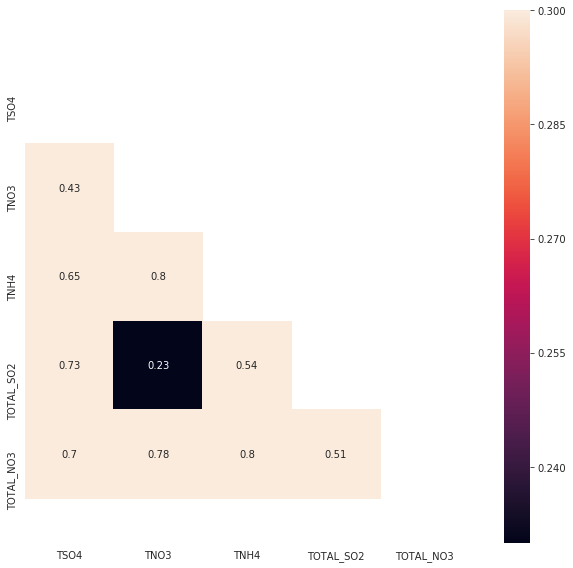

In [126]:

### Correlation among features 

data_sample1 = data[['SITE_ID','DATEON','DATEOFF','TSO4', 'TNO3','TNH4','TOTAL_SO2','TOTAL_NO3',]]

corr = data_sample1.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,annot=True)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.tight_layout()
plt.savefig('htmap.png')

plt.show() 

In [ ]:
## Pairplots 

pairs = data [['TSO4', 'TNO3', 'TNH4', 'Ca', 'Mg',
       'Na', 'K', 'Cl', 'NSO4', 'NHNO3', 'WSO2', 'TOTAL_SO2', 'TOTAL_NO3',
       'FLOW_VOLUME', 'VALID_HOURS']]

sns.pairplot(pairs)

In [ ]:
# sns.pairplot(pairs)


pairs = ['TSO4', 'TNO3', 'TNH4', 'Ca', 'Mg',
       'Na', 'K', 'Cl', 'NSO4', 'NHNO3', 'WSO2', 'TOTAL_SO2', 
       'FLOW_VOLUME', "VALID_HOURS"]


fig, axes = plt.subplots(nrows=2, ncols=7, figsize = (25,6))
fig.suptitle('Distributions of Features')
fig.tight_layout(pad=3.0)

for ax, name in zip(axes.flatten(), pairs):
    sns.scatterplot(data[name], data["TOTAL_NO3"], ax=ax)
    ax.set(title=name[:-4].upper())
    
plt.show()

In [ ]:
## time series analysis 

data.plot("DATEON", "NHNO3", legend=False,figsize=(15,5))

In [ ]:
data.plot("DATEOFF", "NHNO3", legend=False,figsize=(15,5))


In [ ]:
from dateutil.parser import parse 
dateparse = lambda dates: pd.datetimeYtrptime(dates, '%m-%d-%Y')

series = pd.read_csv('https://github.com/dsgovirtual/DSGO-Virtual-Oracle-Hackathon/raw/main/Data/air_status.csv', header=0, parse_dates=[1], index_col=1, squeeze=True)
print(type(series))
print(series.head())
data[data.SITE_ID == 'CON186']

In [ ]:
plt.plot(series['TNO3'])

In [ ]:
plt.plot(series['TNH4'])

In [ ]:
data.shape

In [ ]:
filter1 = data["SITE_ID"] == "YOS404"
filter2 = data["SITE_ID"] == "PIN414"
filter3 = data["SITE_ID"] == "JOT403"
filter4 = data["SITE_ID"] == "LAV410"


new_data = pd.DataFrame(np.concatenate([data[filter1], data[filter2], data[filter3], data[filter4]]),columns = data.columns)
new_data.head()

In [ ]:
## Breaking down to month and years
def convert_to_month(date):
    my_date = datetime.strptime(date, "%Y-%m-%d")
    return my_date.month

def convert_to_year(date):
    my_date = datetime.strptime(date, "%Y-%m-%d")
    return my_date.year


new_data["Month"] = new_data["DATEOFF"].apply(lambda x: convert_to_month(x))
new_data["Year"] = new_data["DATEOFF"].apply(lambda x: convert_to_year(x))
new_data.head()

In [ ]:
new_data.shape

In [ ]:
new_data['QA_CODE'].value_counts()

In [ ]:
new_data.isnull().sum()

In [ ]:
# new_data["Ca"].fillna(new_data["Ca"].mean(), inplace = True)
new_data["Mg"].fillna(new_data["Mg"].mean(), inplace = True)
new_data["Na"].fillna(new_data["Na"].mean(), inplace = True)
new_data["K"].fillna(new_data["K"].mean(), inplace = True)
new_data["Cl"].fillna(new_data["Cl"].mean(), inplace = True)

In [ ]:
new_data.drop(["COMMENT_CODES"], axis = 1, inplace = True)


In [ ]:

X = new_data[['TSO4','TNO3','TNH4','Ca','Mg','Na','K','Cl','NSO4','NHNO3','WSO2','TOTAL_SO2', "VALID_HOURS", "FLOW_VOLUME"]]
y = new_data["TOTAL_NO3"]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
## implementing the ML models

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor


def sum_squared_error( outputs, targets ):
        return (np.sum( np.power(outputs - targets,2)))
    

models = [SVR(), KNeighborsRegressor(), LinearRegression(), Ridge(), Lasso(), RandomForestRegressor()]
models_name = ["SVR", "KNeighborsRegressor", "LinearRegression", "Ridge", "Lasso", "RandomForestRegressor"]

dict_model = dict()

for i, model in enumerate(models):
    m1 = model
    m1.fit(X_train, y_train)
    y_pred = m1.predict(X_test)
    
    dict_model[models_name[i]] = [sum_squared_error(y_pred, y_test), y_pred]
    

print(dict_model)

In [ ]:
for k, v in dict_model.items():
    print(k, v[0])

In [ ]:
X.shape

In [ ]:
## reading the test data file
test_data = pd.read_csv("https://raw.githubusercontent.com/dsgovirtual/DSGO-Virtual-Oracle-Hackathon/main/Data/test.csv")
test_data.head()

In [ ]:
test_X = test_data[['TSO4','TNO3','TNH4','Ca','Mg','Na','K','Cl','NSO4','NHNO3','WSO2','TOTAL_SO2', "VALID_HOURS", "FLOW_VOLUME"]]


In [ ]:
test_X.isnull().sum()

In [ ]:
model_rf = RandomForestRegressor()
model_rf.fit(X, y) 

pred_test_rf = model_rf.predict(test_X)



In [ ]:
df = pd.DataFrame()
df["SITE_ID"] = test_data["SITE_ID"]
df["DATE_ON"] = test_data["DATEON"]
df["TOTAL_NO3"] = list(pred_test_rf)

df.head()



In [ ]:
df.to_csv("Prediction_Test.csv", index = False)

In [ ]:
li = ['TSO4','TNO3','TNH4','Ca','Mg','Na','K','Cl','NSO4','NHNO3','WSO2','TOTAL_SO2', "VALID_HOURS", "FLOW_VOLUME"]
importance = model_rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: {}, Score: {}'.format((li[i]),(v)))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()